# K-Nearest Neighbors Classifier From Scratch 

### Introduction

In this project, I will be implementing my own KNN classifier from scratch using NumPy and use it to classify images of *handwritten digits* from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). This algorithm is one of the simpler ones an ML student will come across, but the ideas can be applied to large-scale sophisticated systems: Semantic Search and Recommendation Systems for starters.

## KNNs from Scratch 
 
I will be using the following libraries: `numpy`, `pandas`, `seaborn`, `matplotlib`, `PIL`, and the standard Python libraries.

### Importing Libraries

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import PIL
import random as r

### Loading the dataset

The MNIST dataset consists of 70,000 labeled images of handwritten digits, each of size 28 pixels by 28 pixels.

The dataset I am using is in a CSV file, `mnist.csv`. The CSV file has roughly 70,000 rows and 785 columns. You can download it using [this link](https://drive.google.com/file/d/16STvH3jEk-JF1BGAguhnA9y0sT_c_MC-/view?usp=sharing).

- Each row represents one image of a handwritten digit and the header row contains the column names.

- The first column gives the label (a number from 0 to 9). The next 784 columns give the value of each pixel. There are 784 pixels in each image corresponding to an image size of 28 by 28.

For faster prototyping, I will be sampling 20% of the entire dataset.

In [7]:

mnist = pd.read_csv('mnist_full.csv')
print("Shape: ", mnist.shape)
print(mnist.head())

Shape:  (70000, 786)
   Unnamed: 0  label  1  2  3  4  5  6  7  8  ...  775  776  777  778  779  \
0           0      5  0  0  0  0  0  0  0  0  ...    0    0    0    0    0   
1           1      0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0   
2           2      4  0  0  0  0  0  0  0  0  ...    0    0    0    0    0   
3           3      1  0  0  0  0  0  0  0  0  ...    0    0    0    0    0   
4           4      9  0  0  0  0  0  0  0  0  ...    0    0    0    0    0   

   780  781  782  783  784  
0    0    0    0    0    0  
1    0    0    0    0    0  
2    0    0    0    0    0  
3    0    0    0    0    0  
4    0    0    0    0    0  

[5 rows x 786 columns]


In [465]:
# sample_size = 14000
sample_size = int(0.2*(mnist.shape[0]))
sample = (mnist.sample(sample_size)).to_numpy()

### Displaying Images

Now that we've loaded the dataset, let's display some images.

You can reshape these 784 values for each image, into a `28x28` array, then use either `matplotlib` or `PIL` to display the image.

In [450]:
def display_image(arr):
    '''
    Takes a 1D numpy array, reshapes to a 28x28 array and displays the image
    '''
    image = arr.reshape(28,28)
    plt.imshow(image, cmap='magma')
    plt.axis('off')
    plt.show()


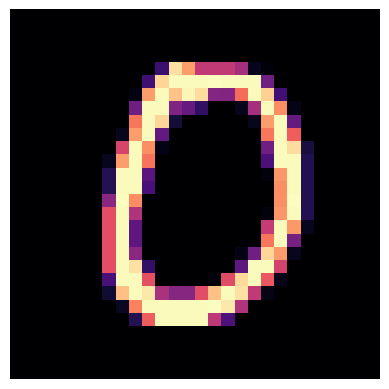

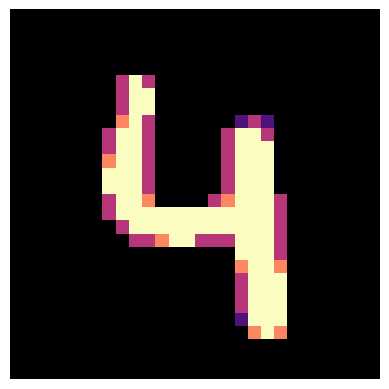

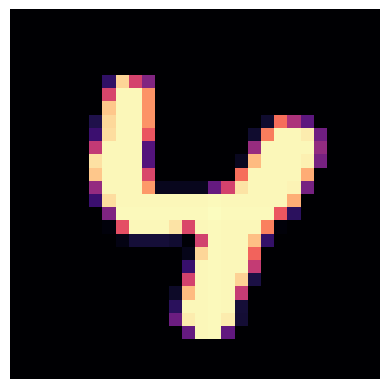

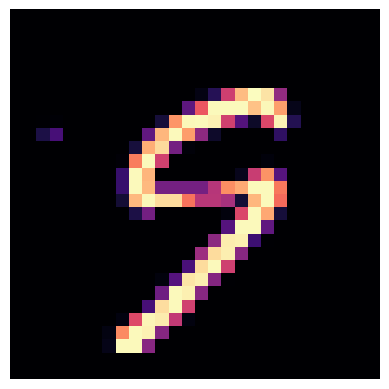

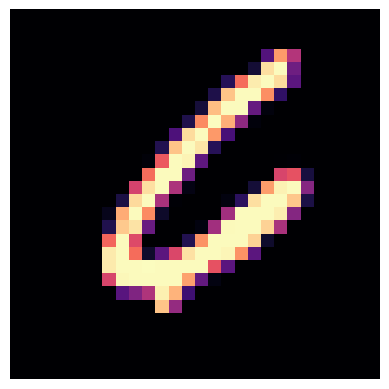

In [451]:
for i in range (5):
    random_idx = r.randint(0, sample_size - 1)
    display_image(sample[random_idx][2:])


### Train-Test split

With the data loaded, we will now set up a proper Cross Validation scheme for our modeling experiments, before we can actually start building our model.

I will divide the dataset into training and test sets (around an 85-15 split). More precisely, taking the first 11900 images for the training set and the last 2100 for the test set.

In [474]:
break_idx = int(0.85*sample_size) + 1
data_train = np.array(sample[:break_idx - 1, 1:])
data_test = np.array(sample[break_idx - 1:, 1:])

print(data_train.shape)
print(data_test.shape)

(11900, 785)
(2100, 785)


In [475]:
train_inputs = data_train[:, 1:]
train_labels = data_train[:, 0]
test_inputs = data_test[:, 1:]
test_labels = data_test[:, 0]

print("Train inputs shape: ", train_inputs.shape)
print("Train labels shape: ", train_labels.shape)
print("Test inputs shape: ", test_inputs.shape)
print("Test labels shape: ", test_labels.shape)

Train inputs shape:  (11900, 784)
Train labels shape:  (11900,)
Test inputs shape:  (2100, 784)
Test labels shape:  (2100,)


### Implementing k-NN Classifier

Now we can create our own k-NN classifier, using the following steps as a guide:

1. For a test data point, find its distance from all training instances.

2. Sort the calculated distances in ascending order based on distance values.

3. Choose k training samples with minimum distances from the test data point.

4. Return the *most frequent* class of these samples. 

For values of `k` where a tie occurs, we will need to break the tie by backing off to the `k-1` value. In case there is still a tie, we will continue decreasing `k` until there is a clear winner.

#### Distance functions

First, I will begin by implementing separate functions for the Euclidean and Manhattan distances:

$$
d_{\text{Euclidean}}(\vec{p},\vec{q}) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + (p_3 - q_3)^2 + ... + (p_n - q_n)^2}
$$

$$
d_{\text{Manhattan}}(\vec{p},\vec{q}) = |(p_1 - q_1)| + |(p_2 - q_2)| + |(p_3 - q_3)| + ... + |(p_n - q_n)|
$$

In [404]:
def euclidean_distance(vector1, vector2):
    
    distE = np.sum((vector1 - vector2)**2)
    
    return np.sqrt(distE)

def manhattan_distance(vector1,vector2):
    
    distM = np.sum(np.absolute(vector1 - vector2))
    
    return distM

# v1 = np.array([1,2,2])
# v2 = np.array([3,5,1])
# v3 = np.array([0,1,4])
# print(manhattan_distance(v2,v1))
# print(euclidean_distance(v3,v2))

#########################

#### k-NN Classifier methods

Now i will complete the following method functions:

1. `fit`

2. `get_neighbours`


3. `predict`

You can make as many helper functions as you need.


In [476]:
class kNearestNeighbours:

  def __init__(self, num_neibrs): 

    """
    n_neighbours: value of k
    X: array of training data points
    y: array of gold labels for training points
    """

    self.n_neighbors = num_neibrs
    self.X = None
    self.y = None
    
    #######################

  
  def fit(self,X_train,y_train):
    '''
    Fit the training data to the model
    '''
    self.X = X_train
    self.y = y_train
  
  def get_neighbors(self, x , distanceFunction):
    """
    Return the k nearest neighbours of the input data point x.
    Hint: you can even just return the indices of the data points

    """
    k = self.n_neighbors
    distances = np.apply_along_axis(distanceFunction, 1, self.X, x) 
    distances = distances.argsort()
    k_neibrs_indices = distances[:k]
    
    return k_neibrs_indices

  def predict(self, X_test, distanceFunction):
    """
    Returns an array of predicted labels for all points in the X_test array

    Parameters
    ----------
    X_test : array
        The test data

    distanceFunction : function
        The distance function to be used
    """
    
    p_labels = []
    
    for datapoint in X_test: 

        k = self.n_neighbors
        
        while k > 0: 

            neighbor_labels = np.sort(self.y[self.get_neighbors(datapoint, distanceFunction)])
            neighbor_labels = neighbor_labels[:k]
            label_counts = np.bincount(neighbor_labels)
            max_count = label_counts.max()
            winners = np.argwhere(label_counts == max_count).flatten()

            if len(winners) == 1: 

                mode = winners[0]
                p_labels.append(mode)
                break
            
            else:

                k -= 1
                
    return np.array(p_labels)

# x = np.array([3, 1, 2])
# print(np.argsort(x))

# amax -> max val
# argmax -> index of max val

# test = kNearestNeighbours(1)
# test.fit(train_inputs, train_labels)
# res = test.predict(test_inputs, euclidean_distance)
# print(res)
# print(test_labels)

#### Evaluation

In [477]:
def calculate_accuracy(predicted_labels, true_labels):
    '''
    Returns the accuracy of the predictions against the true labels
    
    Parameters
    ----------
    predicted_labels : array

    true_labels : array
    """
    '''
    
    correct = np.count_nonzero(predicted_labels == true_labels)
    total = len(predicted_labels)
    
    return correct/total


# acc = correct ans / tot ans

# pred = np.array([1,2,3,5,6,2,5,1])
# gold = np.array([1,1,3,2,63,24,1,11]) # 2/8
# calculate_accuracy(pred, gold)


In [386]:
def make_confusion_matrix(predicted_labels, true_labels):
    '''
    Computes the confusion matrix as a 2D array
    '''
    
    confusion_matrix = np.zeros((10, 10), int)
    
    for i in range(len(predicted_labels)):
        
        confusion_matrix[predicted_labels[i]][true_labels[i]] += 1
    
    return confusion_matrix

In [490]:

def make_heat_map(data, title):
    '''
    Creates a heatmap from the 2D matrix input
    '''
    plt.figure(figsize=(6, 4))
    sns.heatmap(data, annot=True, fmt = "d")  
    plt.title(title)
    plt.xlabel('Gold')
    plt.ylabel('Predicted')
    plt.show()


# make_heat_map([[50, 10], [15, 120]], "Confusion Matrix")

In [389]:
def calculate_precision(confusion_matrix,class_label):
    '''
    Calculates the precision from a provided confusion matrix
    '''
    
    TP = confusion_matrix[class_label][class_label]
    FP = np.sum(confusion_matrix[class_label, :]) - TP
    
    if TP + FP == 0:
        return 0

    return TP / (TP + FP)

# prec = tp/tp+fp

In [390]:
def calculate_recall(confusion_matrix,class_label):
    '''
    Calculates the recall from a provided confusion matrix
    '''
    
    TP = confusion_matrix[class_label][class_label]
    FN = np.sum(confusion_matrix[:, class_label]) - TP
 
    if TP + FN == 0:
        return 0
    
    return TP / (TP + FN)

In [391]:

def calculate_f1_score(precision, recall):
    '''
    Calculates the F1 score from a provided precision and recall
    '''
    
    if precision + recall == 0:
        return 0
    
    return (2 * precision * recall)/(precision + recall)

# F1 = 2PR/P+R

In [392]:

def macro_average_f1(confusion_matrix):
    '''
    Calculates the macro-average F1 score from a provided confusion matrix, over all classes
    '''
    
    macroF1 = 0
    
    for i in range(10): # class labels go from 0-9
        
        R = calculate_recall(confusion_matrix, i)
        P = calculate_precision(confusion_matrix, i)
        macroF1 += calculate_f1_score(P, R)

    return macroF1/10

In [393]:
def evaluation(predicted_labels,true_labels):
    '''
    Computes the Confusion Matrix, Accuracy and Macro-average F1 score from the predictions and true labels
    '''

    confusion_matrix = make_confusion_matrix(predicted_labels, true_labels)    
    accuracy = calculate_accuracy(predicted_labels, true_labels)
    macroF1 = macro_average_f1(confusion_matrix)
    
    return confusion_matrix, accuracy, macroF1

#########################

#### `k`-fold Cross Validation


Now with the basics done, I will move to the next step: `k`-fold Cross Validation. This is a more robust way of evaluating your model since it uses all the data for training and testing (effectively giving you `k` chances to verify the generalizability of your model). In Cross Validation, you divide the dataset into `k` parts. `k-1` parts will be used for training and `1` part will be used for validation. You will repeat this process `k` times, each time using a different part for validation. You will then average the results of each fold to get the final result.

The function should return **predictions** for the **entire training data** (size of list/array should be equal to the size of the dataset). This is the result of appending the predicted labels for each validation-train split into a single list/array. We also need to make sure the order of the predicted labels matches the order of the training dataset, so that they may directly be passed to your `evaluate` function together with the actual labels.

In [478]:
def k_fold_split(k, cv_no, data):
    '''
    Returns the training and validation sets for a given value of k

    Parameters
    ----------
    k : int
        The value of k
    cv_no : int
        The current fold number
    data : array
        The dataset
    '''
    
    chunksize = (int(len(data)/k))
    vset_start = cv_no * chunksize # start at fold num times chunk size then take next chunksize 
    vset_end = vset_start + chunksize 
    
    validation_set = data[vset_start:vset_end]
    training_set = np.concatenate([data[:vset_start], data[vset_end:]]) # train set = dataset - vset

    return training_set,validation_set

In [479]:
def k_fold_cross_validation(num_folds, k, dataset, distanceFunction):
    """
    Returns the predictions for all the data points in the dataset using k-fold cross validation

    num_folds: int
      Number of folds
    k: int
      Number of neighbours to consider (hyperparameter)
    dataset: array
      The dataset to be used (note that this should be the training set which has 11900 samples)
    """
    
    prediction_list = np.zeros(len(dataset), int)
    n = num_folds
    
    for i in range(n):
        
        knn = kNearestNeighbours(k)
        tset, vset = k_fold_split(n, i, dataset)
        
        t_inputs = tset[:, 1:]
        t_labels = tset[:, 0]
        v_inputs = vset[:, 1:]
        v_labels = vset[:, 0]
        
        knn.fit(t_inputs, t_labels)
        fold_start = i * (int(len(dataset)/n))
        fold_end = fold_start + len(vset)
        prediction_list[fold_start:fold_end] = knn.predict(v_inputs, distanceFunction)
    
    return prediction_list


Now we will run our cross-validation function on the training data using `5-fold cross validation` for the values of `k = [1, 2, 3, 4, 5]`. We will do this for both the Euclidean distance and the  Manhattan distance for each value of `k` and finally run my evaluation function for each value of `k` (for both distance metrics) and print out the classification accuracy and F1 score.

In [480]:

print("k=1")

predicted_labels_e1 = k_fold_cross_validation(5, 1, data_train, euclidean_distance)
CM_e1, accuracy_e1, F1_e1 = evaluation(predicted_labels_e1, train_labels)
print("Accuracy (Euclidean): ", accuracy_e1)
print("F1 score (Euclidean): ", F1_e1)

predicted_labels_m1 = k_fold_cross_validation(5, 1, data_train, manhattan_distance)
CM_m1, accuracy_m1, F1_m1 = evaluation(predicted_labels_m1, train_labels)
print("Accuracy (Manhattan): ", accuracy_m1)
print("F1 score (Manhattan): ", F1_m1)

k=1
Accuracy (Euclidean):  0.9525210084033613
F1 score (Euclidean):  0.9520064808117624
Accuracy (Manhattan):  0.9426890756302521
F1 score (Manhattan):  0.9421400611520143


In [481]:

print("k=2")

predicted_labels_e2 = k_fold_cross_validation(5, 2, data_train, euclidean_distance)
CM_e2, accuracy_e2, F1_e2 = evaluation(predicted_labels_e2, train_labels)
print("Accuracy (Euclidean): ", accuracy_e2)
print("F1 score (Euclidean): ", F1_e2)

predicted_labels_m2 = k_fold_cross_validation(5, 2, data_train, manhattan_distance)
CM_m2, accuracy_m2, F1_m2 = evaluation(predicted_labels_m2, train_labels)
print("Accuracy (Manhattan): ", accuracy_m2)
print("F1 score (Manhattan): ", F1_m2)

k=2
Accuracy (Euclidean):  0.9404201680672268
F1 score (Euclidean):  0.9396486000988519
Accuracy (Manhattan):  0.9263865546218487
F1 score (Manhattan):  0.9253360262147131


In [482]:

print("k=3")

predicted_labels_e3 = k_fold_cross_validation(5, 3, data_train, euclidean_distance)
CM_e3, accuracy_e3, F1_e3 = evaluation(predicted_labels_e3, train_labels)
print("Accuracy (Euclidean): ", accuracy_e3)
print("F1 score (Euclidean): ", F1_e3)

predicted_labels_m3 = k_fold_cross_validation(5, 3, data_train, manhattan_distance)
CM_m3, accuracy_m3, F1_m3 = evaluation(predicted_labels_m3, train_labels)
print("Accuracy (Manhattan): ", accuracy_m3)
print("F1 score (Manhattan): ", F1_m3)

k=3
Accuracy (Euclidean):  0.9491596638655462
F1 score (Euclidean):  0.9487351598684592
Accuracy (Manhattan):  0.9394957983193277
F1 score (Manhattan):  0.9391287777630183


In [483]:

print("k=4")

predicted_labels_e4 = k_fold_cross_validation(5, 4, data_train, euclidean_distance)
CM_e4, accuracy_e4, F1_e4 = evaluation(predicted_labels_e4, train_labels)
print("Accuracy (Euclidean): ", accuracy_e4)
print("F1 score (Euclidean): ", F1_e4)

predicted_labels_m4 = k_fold_cross_validation(5, 4, data_train, manhattan_distance)
CM_m4, accuracy_m4, F1_m4 = evaluation(predicted_labels_m4, train_labels)
print("Accuracy (Manhattan): ", accuracy_m4)
print("F1 score (Manhattan): ", F1_m4)


k=4
Accuracy (Euclidean):  0.9471428571428572
F1 score (Euclidean):  0.9468267020514596
Accuracy (Manhattan):  0.9362184873949579
F1 score (Manhattan):  0.9359639070226848


In [484]:

print("k=5")

predicted_labels_e5 = k_fold_cross_validation(5, 5, data_train, euclidean_distance)
CM_e5, accuracy_e5, F1_e5 = evaluation(predicted_labels_e5, train_labels)
print("Accuracy (Euclidean): ", accuracy_e5)
print("F1 score (Euclidean): ", F1_e5)

predicted_labels_m5 = k_fold_cross_validation(5, 5, data_train, manhattan_distance)
CM_m5, accuracy_m5, F1_m5 = evaluation(predicted_labels_m5, train_labels)
print("Accuracy (Manhattan): ", accuracy_m5)
print("F1 score (Manhattan): ", F1_m5)

k=5
Accuracy (Euclidean):  0.9463865546218487
F1 score (Euclidean):  0.9460405235759748
Accuracy (Manhattan):  0.9378991596638655
F1 score (Manhattan):  0.9377611122779292


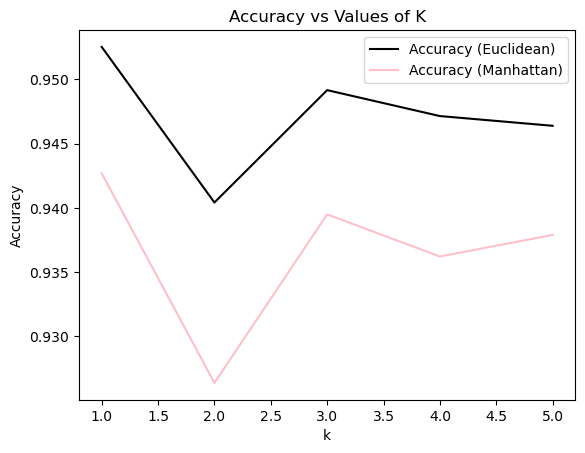

In [485]:
k_values = [1,2,3,4,5]
A_values_E = [accuracy_e1, accuracy_e2, accuracy_e3, accuracy_e4, accuracy_e5]
A_values_M = [accuracy_m1, accuracy_m2, accuracy_m3, accuracy_m4, accuracy_m5]

plt.plot(k_values, A_values_E, label='Accuracy (Euclidean)', color='black')
plt.plot(k_values, A_values_M, label='Accuracy (Manhattan)', color='pink')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Values of K')
plt.legend()

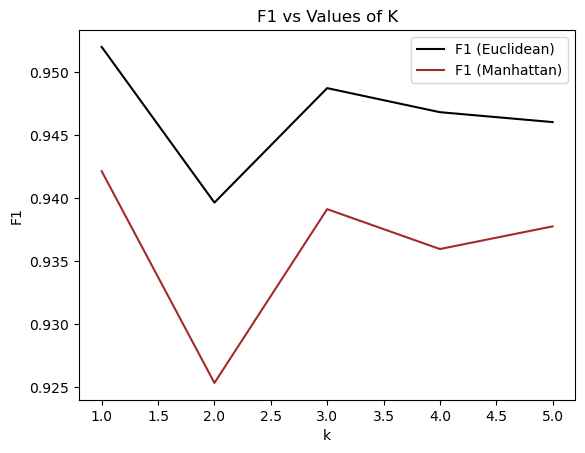

In [486]:
k_values = [1,2,3,4,5]
F1_values_E = [F1_e1, F1_e2, F1_e3, F1_e4, F1_e5]
F1_values_M = [F1_m1, F1_m2, F1_m3, F1_m4, F1_m5]

plt.plot(k_values, F1_values_E, label='F1 (Euclidean)', color='black')
plt.plot(k_values, F1_values_M, label='F1 (Manhattan)', color='brown')
plt.xlabel('k')
plt.ylabel('F1')
plt.title('F1 vs Values of K')
plt.legend()


The best value of k for both distance metrics (euclidean and manhattan) using 5 fold CV is 1. 
This is because k = 1 gives max value of our eval metrics F1 score and classification accuracy.
Decision boundaries generated by model will be very localized, making them sensitive to noisy data and outliers.
k = 1 is prone to overfitting. decisions made are likely to be less stable because decision of test point relies solely on the single nearest neighbour.



Now we will use k=1 (the best value of k for both distance metrics) on the test data.

Accuracy (Euclidean):  0.9161904761904762
F1 score (Euclidean):  0.9132298894717034
Accuracy (Manhattan):  0.9047619047619048
F1 score (Manhattan):  0.9017133708038537


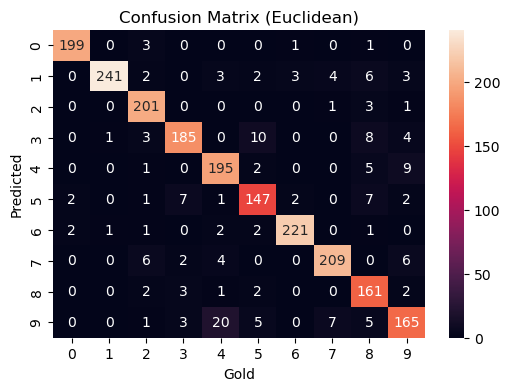

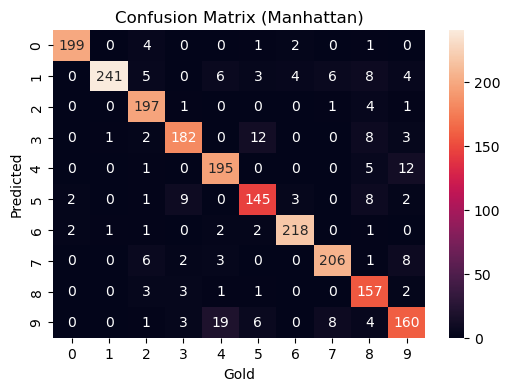

In [491]:

predicted_labels_e = k_fold_cross_validation(5, 1, data_test, euclidean_distance)
CM_e, accuracy_e, F1_e = evaluation(predicted_labels_e, test_labels)
print("Accuracy (Euclidean): ", accuracy_e)
print("F1 score (Euclidean): ", F1_e)

predicted_labels_m = k_fold_cross_validation(5, 1, data_test, manhattan_distance)
CM_m, accuracy_m, F1_m = evaluation(predicted_labels_m, test_labels)
print("Accuracy (Manhattan): ", accuracy_m)
print("F1 score (Manhattan): ", F1_m)


make_heat_map(CM_e, "Confusion Matrix (Euclidean)")
make_heat_map(CM_m, "Confusion Matrix (Manhattan)")

## **Implementation using Scikit-Learn**

In [492]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [498]:
train_inputs = data_train[:, 1:]
train_labels = data_train[:, 0]
test_inputs = data_test[:, 1:]
test_labels = data_test[:, 0]

k_values = [1, 2, 3, 4, 5]

accuracy_E = []
accuracy_M = []

F1_E = []
F1_M = []

CM_E = []
CM_M = [] 

for k in k_values:

    neigh_e = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean')
    acc_scores_e = []
    f1_scores_e = []
    cm_e = np.zeros((10, 10), dtype = int)
    
    neigh_m = KNeighborsClassifier(n_neighbors = k, metric = 'manhattan')
    acc_scores_m = []
    f1_scores_m = []
    cm_m = np.zeros((10, 10), dtype = int)  
    
    for train_index, val_index in (KFold(n_splits = 5)).split(train_inputs):
    
        X_train, X_val = train_inputs[train_index], train_inputs[val_index]
        y_train, y_val = train_labels[train_index], train_labels[val_index]
        
        #euclidean
        neigh_e.fit(X_train, y_train)
        predicted_labels_e = neigh_e.predict(X_val)
        acc_scores_e.append(accuracy_score(y_val, predicted_labels_e))
        report_e = classification_report(y_val, predicted_labels_e, output_dict = True)
        f1_scores_e.append(report_e['macro avg']['f1-score'])
        cm_e += confusion_matrix(y_val, predicted_labels_e)
        
        #manhattan
        neigh_m.fit(X_train, y_train)
        predicted_labels_m = neigh_m.predict(X_val)
        acc_scores_m.append(accuracy_score(y_val, predicted_labels_m))
        report_m = classification_report(y_val, predicted_labels_m, output_dict = True)
        f1_scores_m.append(report_m['macro avg']['f1-score'])
        cm_m += confusion_matrix(y_val, predicted_labels_m)
    
    accuracy_E.append(np.mean(acc_scores_e))
    F1_E.append(np.mean(f1_scores_e))
    CM_E.append(cm_e)
    
    accuracy_M.append(np.mean(acc_scores_m))
    F1_M.append(np.mean(f1_scores_m))
    CM_M.append(cm_m)

print("k Values: ", k_values)
print("Accuracy (Euclidean): ", accuracy_E)
print("Accuracy (Manhattan): ", accuracy_M)
print("F1 (Euclidean): ", F1_E)
print("F1 (Manhattan): ", F1_M)

k Values:  [1, 2, 3, 4, 5]
Accuracy (Euclidean):  [0.9525210084033613, 0.940420168067227, 0.9491596638655462, 0.9471428571428572, 0.9463865546218487]
Accuracy (Manhattan):  [0.9426890756302522, 0.9263865546218488, 0.9395798319327732, 0.936218487394958, 0.9378991596638656]
F1 (Euclidean):  [0.9520408393007079, 0.9395864342319353, 0.948795479409036, 0.9468216226909165, 0.9460795195653791]
F1 (Manhattan):  [0.9420659280917535, 0.9252476411392877, 0.9392739626825467, 0.9359537118850018, 0.9377760422010605]


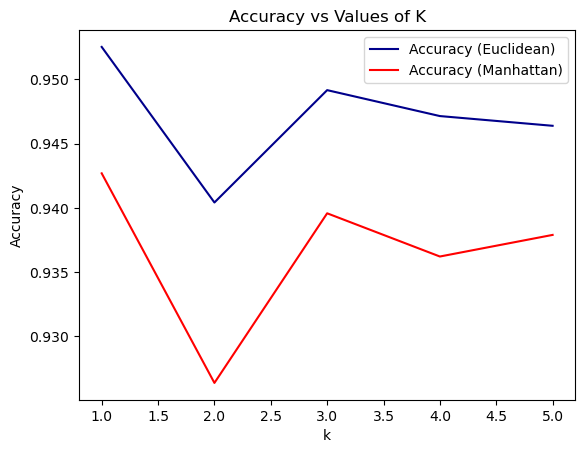

In [501]:
plt.plot(k_values, accuracy_E, label = 'Accuracy (Euclidean)', color = 'darkblue')
plt.plot(k_values, accuracy_M, label = 'Accuracy (Manhattan)', color = 'red')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Values of K')
plt.legend()

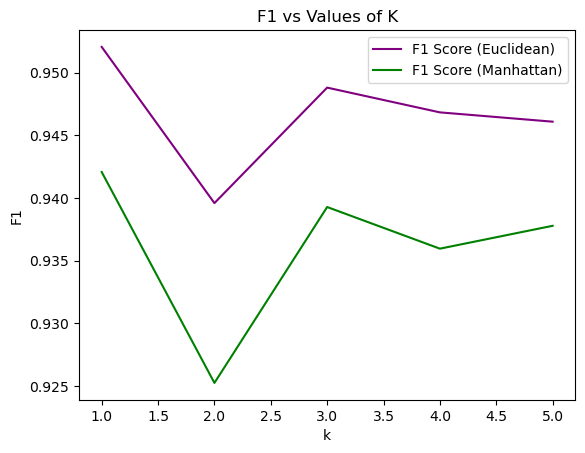

In [506]:
plt.plot(k_values, F1_E, label = 'F1 Score (Euclidean)', color = 'purple')
plt.plot(k_values, F1_M, label = 'F1 Score (Manhattan)', color = 'green')
plt.xlabel('k')
plt.ylabel('F1')
plt.title('F1 vs Values of K')
plt.legend()

Best value of K (Euclidean):  1
Best value of K (Manhattan):  1
Accuracy (Euclidean):  0.9614285714285714
Accuracy (Manhattan):  0.9598365144849034
Accuracy (Euclidean):  0.9495238095238095
Accuracy (Manhattan):  0.9478428121068369


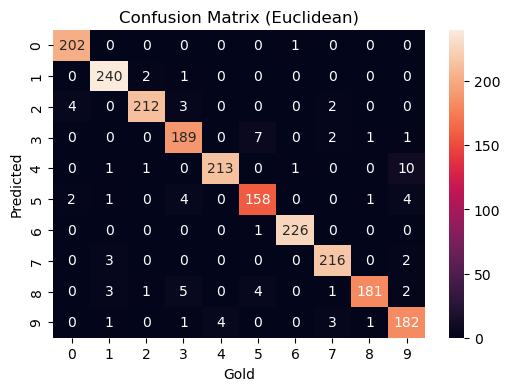

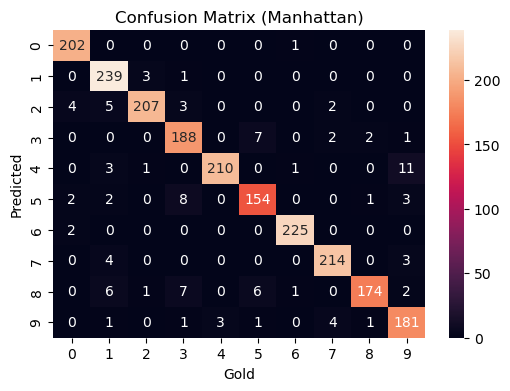

In [515]:
k_opt_e = k_values[F1_E.index(max(F1_E))]
k_opt_m = k_values[F1_M.index(max(F1_M))]

print('Best value of K (Euclidean): ', k_opt_e)
print('Best value of K (Manhattan): ', k_opt_m)

#euclidean
neigh_e_test = KNeighborsClassifier(n_neighbors = k_opt_e, metric = 'euclidean')
neigh_e_test.fit(train_inputs, train_labels)
predicted_labels_e_test = neigh_e_test.predict(test_inputs)
accuracy_e_test = accuracy_score(test_labels, predicted_labels_e_test)
F1_e_test = classification_report(test_labels, predicted_labels_e_test, output_dict = True)['macro avg']['f1-score']
CM_e_test = confusion_matrix(test_labels, predicted_labels_e_test)

#manhattan
neigh_m_test = KNeighborsClassifier(n_neighbors = k_opt_m, metric = 'manhattan')
neigh_m_test.fit(train_inputs, train_labels)
predicted_labels_m_test = neigh_m_test.predict(test_inputs)
accuracy_m_test = accuracy_score(test_labels, predicted_labels_m_test)
F1_m_test = classification_report(test_labels, predicted_labels_m_test, output_dict = True)['macro avg']['f1-score']
CM_m_test = confusion_matrix(test_labels, predicted_labels_m_test)

print("Accuracy (Euclidean): ", accuracy_e_test)
print("Accuracy (Manhattan): ", F1_e_test)
print("Accuracy (Euclidean): ", accuracy_m_test)
print("Accuracy (Manhattan): ", F1_m_test)
make_heat_map(CM_e_test, "Confusion Matrix (Euclidean)")
make_heat_map(CM_m_test, "Confusion Matrix (Manhattan)")


# Testing my kNN classifier with my own handwriting!

Gradio is an open-source Python library that is used to build machine learning and data science demos and web applications. 

I will use the sketchpad interface to write my digits and pass that to my classifier.  

In [516]:
# !pip install gradio
import gradio as gr

In [518]:
my_classifier = kNearestNeighbours(3)
my_classifier.fit(train_inputs, train_labels)

my_sk_classifer = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
my_sk_classifer.fit(train_inputs, train_labels)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [520]:
def sketch_recognition(img):

    image_arr = img.flatten()


    # label = my_classifier.predict([image_arr],EuclideanDistance)

    label = my_sk_classifer.predict([image_arr])

    print("Your label: ",label[0])
    return str(label[0])


In [522]:
iface = gr.Interface(fn=sketch_recognition, inputs="sketchpad", outputs="text")
iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


In [523]:
### Draw and save your handwritten digits as an image (if you want)

gr.Interface(lambda x:x, "sketchpad", "image").launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


/Users/ajm/anaconda3/lib/python3.11/site-packages/gradio/components/button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


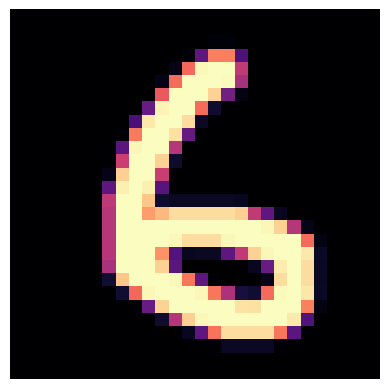

Your label:  6


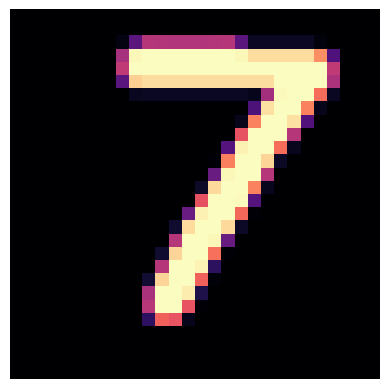

Your label:  2


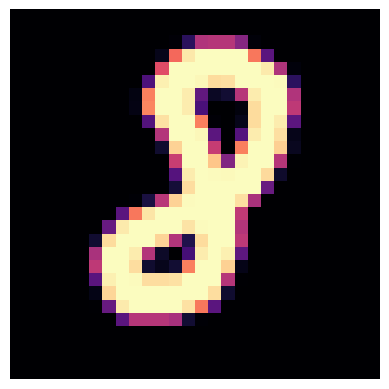

Your label:  8


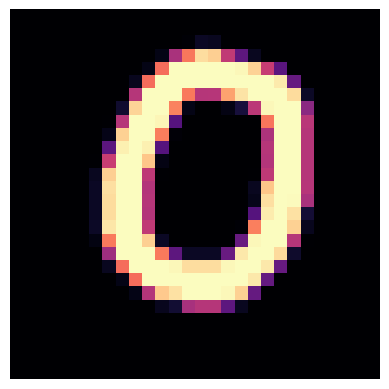

Your label:  0


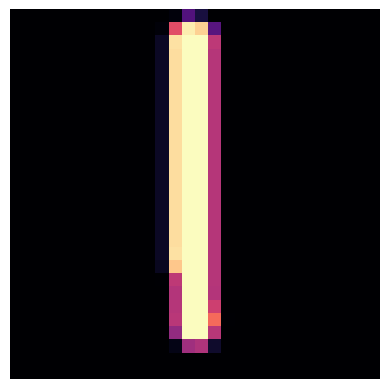

Your label:  1


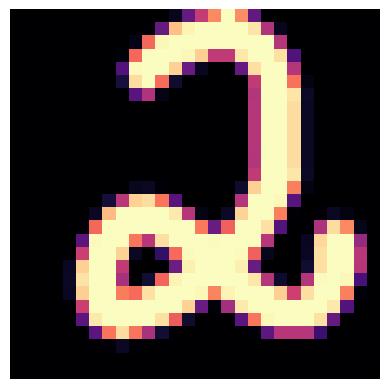

Your label:  2


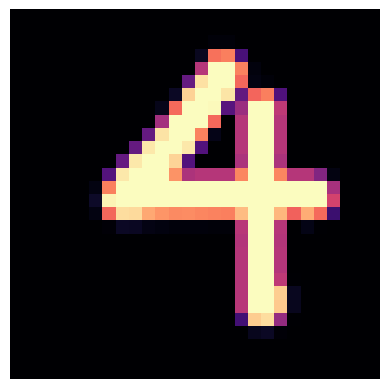

Your label:  4


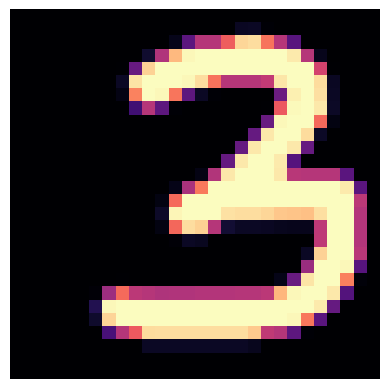

Your label:  2


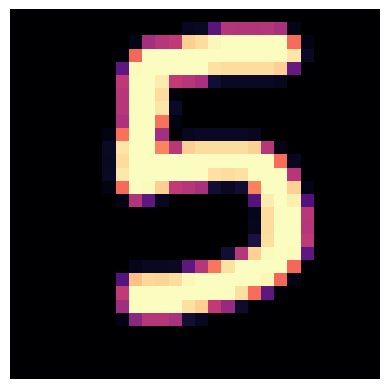

Your label:  5


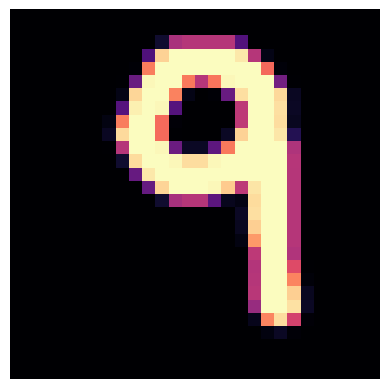

Your label:  3


In [535]:
## (5 marks)
## TODO: Use images of your own handwritten digits and make a prediction using your own classifier.
## You can use the sketchpad above if you'd like or even use pencil and paper to write out some numbers and then take a picture.

from PIL import Image

img1 = Image.open('img1.png')
img2 = Image.open('img2.png')
img3 = Image.open('img3.png')
img4 = Image.open('img4.png')
img5 = Image.open('img5.png')
img6 = Image.open('img6.png')
img7 = Image.open('img7.png')
img8 = Image.open('img8.png')
img9 = Image.open('img9.png')
img10 = Image.open('img10.png')

images = [img1, img2, img3, img4, img5, img6, img7, img8, img9, img10]

for img in images:
    
    img = np.array(img).reshape(784)
    display_image(img)
    sketch_recognition(img)


## Display five of these images and print out the corresponding prediction
## You can use either your own classifier or sklearn.



## Have fun!!

## Fin.